In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

In [2]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BATCH_SIZE = 64
BUFFER_SIZE = 1024
IMG_SIZE = (380,380)

SEED = 44

In [3]:
eff_train_ds = load_tfrecord("records/eff_ens_train.tfrecord", BATCH_SIZE, "efficientnet").repeat()
eff_val_ds = load_tfrecord("records/eff_ens_val.tfrecord", BATCH_SIZE, "efficientnet")
res_train_ds = load_tfrecord("records/res_ens_train.tfrecord", BATCH_SIZE, "resnet").repeat()
res_val_ds = load_tfrecord("records/res_ens_val.tfrecord", BATCH_SIZE, "resnet")

In [4]:
res_model=keras.saving.load_model("./models/resnet_tuned_best_v32131289_blur_nomix_focal.keras")
eff_model=keras.saving.load_model("./models/efficientnet_tuned_blur_no_cutmix.keras")

In [ ]:
#fit pred into models and build datasets
res_pred_train_x=res_model.predict(res_train_ds)
res_pred_val_x=res_model.predict(res_val_ds)
eff_pred_train_x=eff_model.predict(eff_train_ds)
eff_pred_val_x=eff_model.predict(eff_val_ds)
ens_train_ds=tf_data.Dataset.from_tensor_slices((res_pred_train_x,eff_pred_train_x,res_train_ds))
ens_val_ds=tf_data.Dataset.from_tensor_slices((res_pred_val_x,eff_pred_val_x,res_val_ds))
ens_train_ds=ens_train_ds.map(lambda x,y,z: (tf.convert_to_tensor((float(x[0]),float(y[0]))),z))
ens_val_ds=ens_val_ds.map(lambda x,y,z: (tf.convert_to_tensor((float(x[0]),float(y[0]))),z))
#get the prob of label1 as input only

   9311/Unknown 19381s 2s/step

KeyboardInterrupt: 

In [ ]:
#Build Neural Network Model, but we end up using simpler model 
input=keras.layers.Input(shape=(2,))
x=keras.layers.Dense(8)(input)
x = keras.layers.Dropout(0.1, seed=SEED)(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
ens_model=keras.Model(input,outputs)
lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=9e-5,
        first_decay_steps=20, 
        t_mul=2.0,  # Restarts period multiplier
        m_mul=0.9  # Decay factor after each restart
    )
ens_model.compile(optimizer=keras.optimizers.AdamW(lr_schedule),
                    loss=keras.losses.CategoricalFocalCrossentropy(alpha=1.0),
                    metrics=[keras.metrics.AUC(multi_label=True),
                            keras.metrics.F1Score("macro")])
early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=2, min_delta=0.01, mode="max")
save_model = keras.callbacks.ModelCheckpoint(f'ens_res_eff.keras', save_best_only=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/ensemble")
ens_model.fit(
    ens_train_ds,
    validation_data=ens_val_ds,
    epochs=10,
    steps_per_epoch=10,
    callbacks=[early_stopping,
               save_model,
               tensorboard_callback]

)

Epoch 1/10


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(2,), dtype=float32). Expected shape (None, 2), but input has incompatible shape (2,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(2,), dtype=float32)
  • training=True
  • mask=None

Due to time and resource issues this has not been trained and tested. The following is just some plotting to deduct possible generalizer that we could use.

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 38s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 38s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 38s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 41s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 951ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 87s 42s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 880ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 44s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 862ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 41s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 854ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 39s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 898ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 38s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 38s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 38s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 37s/step

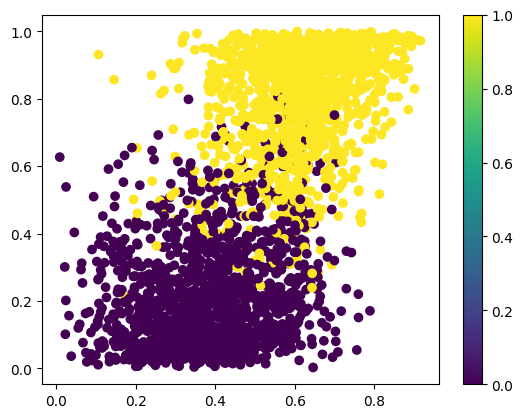

In [ ]:
idx=0
r_p=[]
e_p=[]
l_list=[]
for i,j in zip(res_train_ds, eff_train_ds):
    idx+=1
    x,l=i
    y,k=j
    pred_r=res_model.predict(x)
    pred_e=eff_model.predict(y)
    ds=tf_data.Dataset.from_tensor_slices((pred_r,pred_e,l)).map(lambda res_1,  eff_1, y: (res_1[0], eff_1[0], y[0]))
    ds=ds.as_numpy_iterator()
    for i in ds:
        r_p.append(i[0])
        e_p.append(i[1])
        l_list.append(i[2])
    if idx>40:
        break


    
    



In [ ]:
#Load validation set
idx=0
r_p_val=[]
e_p_val=[]
l_list_val=[]
for i,j in zip(res_val_ds, eff_val_ds):
    idx+=1
    x,l=i
    y,k=j
    pred_r=res_model.predict(x)
    pred_e=eff_model.predict(y)
    ds=tf_data.Dataset.from_tensor_slices((pred_r,pred_e,l)).map(lambda res_1,  eff_1, y: (res_1[0], eff_1[0], y[0]))
    ds=ds.as_numpy_iterator()
    for i in ds:
        r_p_val.append(i[0])
        e_p_val.append(i[1])
        l_list_val.append(i[2])
    if idx>10:
        break


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 41s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 889ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 89s 41s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 878ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 90s 50s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 872ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 42s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 935ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 105s 63s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 997ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 87s 42s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 890ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 121s 69s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 92s 47s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 118s 51s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 976ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 113s 65s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 98s 50s/step


3328


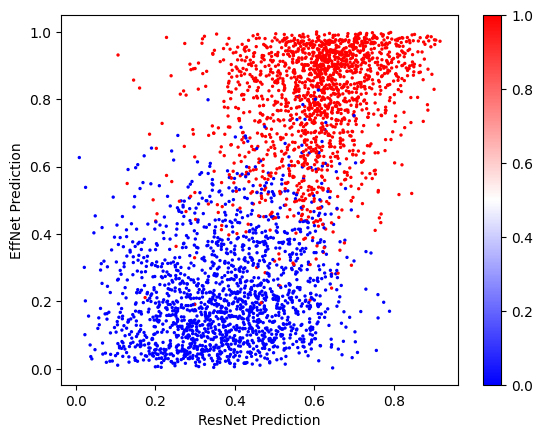

In [110]:
print(len(r_p))
plt.scatter(r_p,e_p,c=l_list,s=2,cmap="bwr")
plt.xlabel("ResNet Prediction")
plt.ylabel("EffNet Prediction")
plt.colorbar()


Given the output shape of the predicted probability here, we can consider RandomForest Classifier, Logistic Regression or Support Vector Machines to do the generalization of the resnet and Efficient Net models, or more complicated models like Multi-Layer Percepton.

In [127]:
X_train=np.array([r_p,e_p]).T
y_train=np.array(l_list)
X_val=np.array([r_p_val,e_p_val]).T
y_val=np.array(l_list_val)

In [133]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier()
rf_clf.fit(X_train,y_train)
print(rf_clf.score(X_train,y_train))
print(rf_clf.score(X_val,y_val))


1.0
0.9354354354354354


In [134]:
from sklearn.svm import SVC
svm_clf=SVC(kernel='linear')
svm_clf.fit(X_train,y_train)
print(svm_clf.score(X_train,y_train))
print(svm_clf.score(X_val,y_val))

0.9444027047332832
0.9459459459459459


In [135]:
from sklearn.linear_model import LogisticRegression
log_clf=LogisticRegression()
log_clf.fit(X_train,y_train)
print(log_clf.score(X_train,y_train))
print(log_clf.score(X_val,y_val))


0.944778362133734
0.9459459459459459


In [ ]:
test_ds_eff = load_test_tfrecord("records/efficientnet_test.tfrecord", BATCH_SIZE, "efficientnet")
test_ds_res = load_test_tfrecord("records/resnet_test.tfrecord", BATCH_SIZE, "resnet")


In [137]:
res_pred_test_x=res_model.predict(test_ds_res)
eff_pred_test_x=eff_model.predict(test_ds_eff)

87/87 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step


c:\Users\shenw\Downloads\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


87/87 ━━━━━━━━━━━━━━━━━━━━ 8365s 96s/step


In [151]:

r_test=[]
e_test=[]

for i, j in zip(res_pred_test_x,eff_pred_test_x):
    r_test.append(i[0])
    e_test.append(j[0])


In [ ]:
X_test=np.array([r_test,e_test]).T



In [154]:
y_test_svm=svm_clf.predict(X_test)
y_test_log=log_clf.predict(X_test)
y_test_rf=rf_clf.predict(X_test)

In [ ]:
filename="records/Eff_Test_X.pkl"
import pickle
with open(filename,'wb') as f:
    pickle.dump(eff_pred_test_x,f)

    

In [155]:
models_dict={"log":log_clf,"svm":svm_clf,"rf":rf_clf}
for i in ["log","svm","rf"]:
 with open("models/"+i,'wb') as f:
   pickle.dump(models_dict[i],f)

In [168]:
import csv
test_df = pd.read_csv('./archive/test.csv')
test_paths = test_df["id"].array
content=np.column_stack([test_paths,y_test_svm])
fmt='%s,%d'
np.savetxt("ensemble_svm_submission.csv",content, fmt=fmt, delimiter=',')